In [9]:
# %% [code] {verticalOutput: true}
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm.keras import TqdmCallback
from tqdm import tqdm

# Configuration
IMG_ROWS, IMG_COLS = 32, 32
BATCH_SIZE = 32
EPOCHS_TRANSFER = 20
EPOCHS_FINETUNE = 10
EPSILON = 0.03

# Configuration


# %% [code] {verticalOutput: true}
# Data Loading with Progress Bars
def load_data_with_progress():
    PATH = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
    TEST_PATH = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"
    
    def load_images(path, label, desc):
        images = []
        labels = []
        files = list(os.listdir(path))[:10000]  # Limit for demo
        for f in tqdm(files, desc=desc):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(path, f), 
                target_size=(IMG_ROWS, IMG_COLS)
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label)
        return np.array(images), np.array(labels)
    
    # Load with progress bars
    print("Loading training data...")
    real_X, real_y = load_images(os.path.join(PATH, 'REAL'), 0, 'REAL images')
    fake_X, fake_y = load_images(os.path.join(PATH, 'FAKE'), 1, 'FAKE images')
    
    print("\nLoading test data...")
    test_real_X, test_real_y = load_images(os.path.join(TEST_PATH, 'REAL'), 0, 'Test REAL')
    test_fake_X, test_fake_y = load_images(os.path.join(TEST_PATH, 'FAKE'), 1, 'Test FAKE')
    
    # Combine and normalize
    X = np.concatenate([real_X, fake_X]) / 255.0
    y = np.concatenate([real_y, fake_y])
    X_test = np.concatenate([test_real_X, test_fake_X]) / 255.0
    y_test = np.concatenate([test_real_y, test_fake_y])
    
    return X, y, X_test, y_test

X_train, y_train, X_test, y_test = load_data_with_progress()

# %% [code] {verticalOutput: true}
# Model Building
def build_model():
    base = keras.applications.EfficientNetB2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_ROWS, IMG_COLS, 3),
        pooling=None
    )
    base.trainable = False
    
    inputs = keras.Input(shape=(IMG_ROWS, IMG_COLS, 3))
    x = base(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    return model

model = build_model()

# %% [code] {verticalOutput: true}
# Training with Enhanced Progress
def train_model(model, X, y, epochs, validation_split=0.1):
    # Split validation
    idx = np.random.permutation(len(X))
    split = int(len(X) * validation_split)
    X_val, y_val = X[idx[:split]], y[idx[:split]]
    X_train, y_train = X[idx[split:]], y[idx[split:]]
    
    # Custom progress callback
    class ProgressCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            print(f"\nEpoch {epoch+1}/{epochs} - "
                  f"loss: {logs['loss']:.4f} - "
                  f"acc: {logs['binary_accuracy']:.4f} - "
                  f"val_loss: {logs['val_loss']:.4f} - "
                  f"val_acc: {logs['val_binary_accuracy']:.4f}")
    
    print(f"\nTraining for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[
            TqdmCallback(verbose=1),
            ProgressCallback(),
            keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ]
    )
    return history



Loading training data...


FAKE images: 100%|██████████| 10000/10000 [01:13<00:00, 136.34it/s]



Loading test data...


Test FAKE: 100%|██████████| 10000/10000 [01:21<00:00, 122.49it/s]


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [30]:
# Transfer Learning
print("=== TRANSFER LEARNING PHASE ===")
transfer_history = train_model(model, X_train, y_train, EPOCHS_TRANSFER)

# %% [code] {verticalOutput: true}
# Fine-tuning
print("\n=== FINE-TUNING PHASE ===")
model.layers[1].trainable = True  # Unfreeze base
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

finetune_history = train_model(model, X_train, y_train, EPOCHS_FINETUNE)



=== TRANSFER LEARNING PHASE ===

Training for 20 epochs...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1/20 - loss: 0.2893 - acc: 0.8770 - val_loss: 0.2253 - val_acc: 0.9145

Epoch 2/20 - loss: 0.2729 - acc: 0.8854 - val_loss: 0.2149 - val_acc: 0.9185

Epoch 3/20 - loss: 0.2646 - acc: 0.8923 - val_loss: 0.2067 - val_acc: 0.9195

Epoch 4/20 - loss: 0.2534 - acc: 0.8942 - val_loss: 0.2022 - val_acc: 0.9200

Epoch 5/20 - loss: 0.2457 - acc: 0.8993 - val_loss: 0.1946 - val_acc: 0.9280

Epoch 6/20 - loss: 0.2294 - acc: 0.9044 - val_loss: 0.1914 - val_acc: 0.9300

Epoch 7/20 - loss: 0.2180 - acc: 0.9114 - val_loss: 0.1875 - val_acc: 0.9310

Epoch 8/20 - loss: 0.2118 - acc: 0.9106 - val_loss: 0.1813 - val_acc: 0.9310

Epoch 9/20 - loss: 0.2062 - acc: 0.9176 - val_loss: 0.1769 - val_acc: 0.9330

Epoch 10/20 - loss: 0.1970 - acc: 0.9213 - val_loss: 0.1733 - val_acc: 0.9355

Epoch 11/20 - loss: 0.1877 - acc: 0.9253 - val_loss: 0.1718 - val_acc: 0.9370

Epoch 12/20 - loss: 0.1874 - acc: 0.9221 - val_loss: 0.1702 - val_acc: 0.9380

Epoch 13/20 - loss: 0.1733 - acc: 0.9297 - val_loss: 0.1665 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1/10 - loss: 0.1456 - acc: 0.9436 - val_loss: 0.0704 - val_acc: 0.9845

Epoch 2/10 - loss: 0.1398 - acc: 0.9467 - val_loss: 0.0728 - val_acc: 0.9815

Epoch 3/10 - loss: 0.1372 - acc: 0.9472 - val_loss: 0.0718 - val_acc: 0.9800

Epoch 4/10 - loss: 0.1330 - acc: 0.9488 - val_loss: 0.0702 - val_acc: 0.9800

Epoch 5/10 - loss: 0.1282 - acc: 0.9510 - val_loss: 0.0670 - val_acc: 0.9795

Epoch 6/10 - loss: 0.1242 - acc: 0.9521 - val_loss: 0.0682 - val_acc: 0.9775

Epoch 7/10 - loss: 0.1221 - acc: 0.9531 - val_loss: 0.0666 - val_acc: 0.9790

Epoch 8/10 - loss: 0.1164 - acc: 0.9557 - val_loss: 0.0661 - val_acc: 0.9785

Epoch 9/10 - loss: 0.1223 - acc: 0.9531 - val_loss: 0.0679 - val_acc: 0.9785

Epoch 10/10 - loss: 0.1116 - acc: 0.9571 - val_loss: 0.0680 - val_acc: 0.9765


In [71]:
# %% [code] {verticalOutput: true}
# Print detailed summary
model.summary(line_length=100)

# Calculate total parameters
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"\nTotal Parameters: {trainable_params + non_trainable_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ efficientnetb2 (Functional)                │ (None, 1, 1, 1408)              │         7,768,569 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ global_average_pooling2d_2                 │ (None, 1408)                    │                 0 │
│ (GlobalAveragePooling2D)                   │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_4 (Dense)                            │ (None, 1)                       │             1,409 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 23,174,786 (88.40 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

 Optimizer params: 15,404,808 (58.76 MB)


Total Parameters: 7,769,978.0
Trainable Parameters: 7,702,403
Non-Trainable Parameters: 67,575.0


In [73]:
# %% [code] {verticalOutput: true}
import time

# Warm-up
model.predict(X_test[:1], verbose=0)

# Benchmark inference
times = []
for _ in range(100):
    start = time.time()
    model.predict(X_test[:1], verbose=0)
    times.append(time.time() - start)
    
print(f"Average Inference Time: {np.mean(times)*1000:.2f}ms (±{np.std(times)*1000:.2f}ms)")
print(f"FPS: {1/np.mean(times):.2f}")

Average Inference Time: 60.28ms (±2.80ms)
FPS: 16.59


In [40]:
# %% [code] {verticalOutput: true}
# Save the complete model (architecture + weights + optimizer state)
model.save("efficientnet_cifake_complete.keras")  # or .h5 for HDF5 format
print("Full model saved successfully!")

Full model saved successfully!


In [61]:
EPSILON = 0.03  # Attack strength (0-1)
PGD_STEPS = 10  # Number of PGD iterations
ALPHA = 0.01    # PGD step size
NUM_SAMPLES = 2000  # Number of samples to attack

In [21]:
# %% [code] {verticalOutput: true}
# Adversarial Attack Functions
def fgsm_attack(model, images, labels, epsilon=EPSILON):
    """
    Fast Gradient Sign Method (FGSM) Attack
    """
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tensor = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor, training=False)
        loss = keras.losses.binary_crossentropy(labels_tensor, predictions)
    
    gradients = tape.gradient(loss, images_tensor)
    signed_grad = tf.sign(gradients)
    adv_images = images_tensor + epsilon * signed_grad
    adv_images = tf.clip_by_value(adv_images, 0, 1)  # Maintain valid pixel range
    
    return adv_images.numpy()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=0.01, iterations=10):
    """
    Projected Gradient Descent (PGD) Attack
    """
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tensor = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))
    adv_images = tf.identity(images_tensor)
    
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images, training=False)
            loss = keras.losses.binary_crossentropy(labels_tensor, predictions)
        
        gradients = tape.gradient(loss, adv_images)
        perturbations = alpha * tf.sign(gradients)
        adv_images = adv_images + perturbations
        
        # Project back to epsilon neighborhood
        perturbation = tf.clip_by_value(adv_images - images_tensor, -epsilon, epsilon)
        adv_images = images_tensor + perturbation
        
        # Clip to valid pixel range [0,1]
        adv_images = tf.clip_by_value(adv_images, 0, 1)
    
    return adv_images.numpy()

# %% [code] {verticalOutput: true}
# Adversarial Evaluation Function
def evaluate_adversarial(model, X_test, y_test, attack_fn, attack_name, num_samples=2000):
    """
    Evaluate model on adversarial examples with progress bar
    """
    # Select random subset for evaluation
    idx = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    X_sample, y_sample = X_test[idx], y_test[idx]
    
    # Generate adversarial examples
    with tqdm(total=len(X_sample), desc=f"Generating {attack_name} samples") as pbar:
        X_adv = attack_fn(model, X_sample, y_sample)
        pbar.update(len(X_sample))
    
    # Evaluate the model on adversarial examples
    results = model.evaluate(X_adv, y_sample, verbose=0)
    
    # Extract accuracy from results
    if isinstance(results, list):
        # If model returns multiple metrics
        mean_acc = results[1]  # Assuming accuracy is the second metric
    else:
        # If model returns only loss
        mean_acc = results
    
    print(f"{attack_name} Attack Accuracy: {mean_acc:.4f}")
    return X_adv, mean_acc

In [29]:

# %% [code] {verticalOutput: true}
# Run Adversarial Evaluations
print("\n=== ADVERSARIAL EVALUATION ===")

# 1. First evaluate clean accuracy
clean_loss, clean_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Clean Test Accuracy: {clean_acc:.4f}")

# 2. Evaluate FGSM attack
X_fgsm, fgsm_acc = evaluate_adversarial(model, X_test, y_test, fgsm_attack, "FGSM")

# 3. Evaluate PGD attack
X_pgd, pgd_acc = evaluate_adversarial(model, X_test, y_test, pgd_attack, "PGD")



=== ADVERSARIAL EVALUATION ===
Clean Test Accuracy: 0.5000


Generating FGSM samples: 100%|██████████| 2000/2000 [00:00<00:00, 2482.59it/s]


FGSM Attack Accuracy: 0.5145


Generating PGD samples: 100%|██████████| 2000/2000 [00:07<00:00, 262.75it/s]


PGD Attack Accuracy: 0.5045


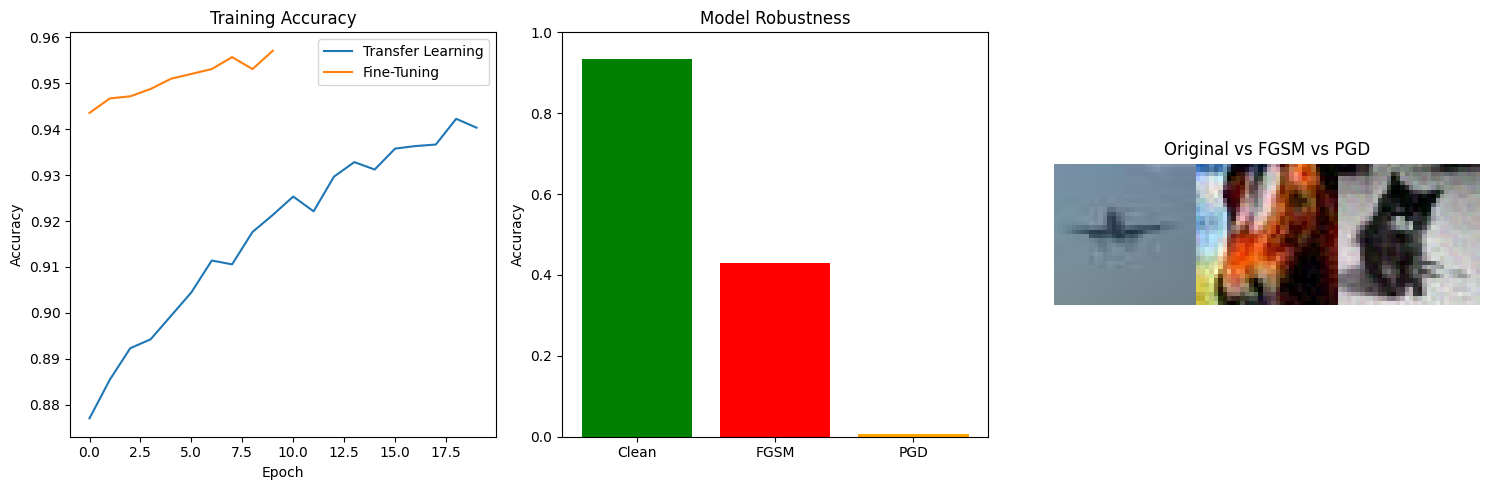

Adversarial examples saved to 'adversarial_examples.npz'


In [64]:

# %% [code] {verticalOutput: true}
# Visualization of Results
plt.figure(figsize=(15, 5))

# 1. Training History
plt.subplot(1, 3, 1)
plt.plot(transfer_history.history['binary_accuracy'], label='Transfer Learning')
plt.plot(finetune_history.history['binary_accuracy'], label='Fine-Tuning')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Robustness Comparison
plt.subplot(1, 3, 2)
plt.bar(['Clean', 'FGSM', 'PGD'], 
        [clean_acc, fgsm_acc, pgd_acc],
        color=['green', 'red', 'orange'])
plt.title('Model Robustness')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# 3. Example Adversarial Images
plt.subplot(1, 3, 3)
plt.imshow(np.concatenate([
    X_test[0], 
    X_fgsm[0], 
    X_pgd[0]
], axis=1))
plt.title('Original vs FGSM vs PGD')
plt.axis('off')

plt.tight_layout()
plt.show()

# %% [code] {verticalOutput: true}
# Save Adversarial Examples for Later Use
np.savez('adversarial_examples.npz',
         X_clean=X_test[:1000],
         X_fgsm=X_fgsm,
         X_pgd=X_pgd,
         y_test=y_test[:1000])

print("Adversarial examples saved to 'adversarial_examples.npz'")

In [3]:
# %% [code] {verticalOutput: true}
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.keras import TqdmCallback
from tqdm import tqdm
import time

# Load the saved model instead of retraining
print("Loading the saved model...")
model = keras.models.load_model("/kaggle/input/efficientnet_baseline/keras/default/1/efficientnet_cifake_complete.keras")



Loading the saved model...


In [20]:
BATCH_SIZE = 32
EPOCHS_ADV = 1  # Number of epochs for adversarial training
EPSILON = 0.03  # Attack strength
ALPHA = 0.01  # Step size for PGD
PGD_STEPS = 10  # Number of PGD steps
NUM_SAMPLES = 2000  # Number of samples for evaluation

# %% [code] {verticalOutput: true}
# Function to generate adversarial examples on-the-fly
def generate_adversarial_batch(model, x_batch, y_batch, epsilon=EPSILON, alpha=ALPHA, attack_type='fgsm'):
    """
    Generate adversarial examples for a batch
    
    Args:
        model: The model being attacked
        x_batch: Input images
        y_batch: True labels
        epsilon: Attack strength
        alpha: Step size (for PGD)
        attack_type: 'fgsm' or 'pgd'
        
    Returns:
        Adversarial examples
    """
    x_tensor = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_tensor = tf.reshape(tf.convert_to_tensor(y_batch, dtype=tf.float32), (-1, 1))
    
    if attack_type == 'fgsm':
        # FGSM attack
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            predictions = model(x_tensor, training=False)
            loss = keras.losses.binary_crossentropy(y_tensor, predictions)
        
        gradients = tape.gradient(loss, x_tensor)
        signed_grad = tf.sign(gradients)
        adv_x = x_tensor + epsilon * signed_grad
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        
    elif attack_type == 'pgd':
        # PGD attack
        adv_x = tf.identity(x_tensor)
        
        for _ in range(PGD_STEPS):
            with tf.GradientTape() as tape:
                tape.watch(adv_x)
                predictions = model(adv_x, training=False)
                loss = keras.losses.binary_crossentropy(y_tensor, predictions)
            
            gradients = tape.gradient(loss, adv_x)
            perturbations = alpha * tf.sign(gradients)
            adv_x = adv_x + perturbations
            
            # Project back to epsilon neighborhood
            perturbation = tf.clip_by_value(adv_x - x_tensor, -epsilon, epsilon)
            adv_x = x_tensor + perturbation
            
            # Clip to valid pixel range [0,1]
            adv_x = tf.clip_by_value(adv_x, 0, 1)
    
    return adv_x

In [12]:



# %% [code] {verticalOutput: true}
# Adversarial training function
def adversarial_training(model, X_train, y_train, epochs, attack_type='mixed', validation_split=0.1):
    """
    Perform adversarial training
    
    Args:
        model: Model to train
        X_train: Training images
        y_train: Training labels
        epochs: Number of epochs
        attack_type: 'fgsm', 'pgd', or 'mixed'
        validation_split: Fraction of data to use for validation
        
    Returns:
        Training history
    """
    # Create validation set
    idx = np.random.permutation(len(X_train))
    split = int(len(X_train) * validation_split)
    X_val, y_val = X_train[idx[:split]], y_train[idx[:split]]
    X_train_split, y_train_split = X_train[idx[split:]], y_train[idx[split:]]
    
    # For tracking metrics
    history = {'loss': [], 'binary_accuracy': [], 'val_loss': [], 'val_binary_accuracy': []}
    
    # Custom training loop with adversarial examples
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Shuffle training data
        indices = np.random.permutation(len(X_train_split))
        X_train_epoch = X_train_split[indices]
        y_train_epoch = y_train_split[indices]
        
        # Training loop with progress bar
        epoch_loss = []
        epoch_acc = []
        
        with tqdm(total=len(X_train_epoch) // BATCH_SIZE, desc=f"Training") as pbar:
            for i in range(0, len(X_train_epoch), BATCH_SIZE):
                x_batch = X_train_epoch[i:i+BATCH_SIZE]
                y_batch = y_train_epoch[i:i+BATCH_SIZE]
                
                # Generate adversarial examples
                if attack_type == 'mixed':
                    # Alternate between FGSM and PGD
                    if np.random.random() > 0.5:
                        current_attack = 'fgsm'
                    else:
                        current_attack = 'pgd'
                else:
                    current_attack = attack_type
                
                adv_x_batch = generate_adversarial_batch(model, x_batch, y_batch, 
                                                         attack_type=current_attack)
                
                # Combine clean and adversarial examples (50/50)
                combined_x = tf.concat([x_batch, adv_x_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Train on combined batch
                with tf.GradientTape() as tape:
                    predictions = model(combined_x, training=True)
                    loss_value = keras.losses.binary_crossentropy(
                        tf.reshape(combined_y, (-1, 1)), predictions)
                    loss_value = tf.reduce_mean(loss_value)
                
                # Get gradients and update weights
                grads = tape.gradient(loss_value, model.trainable_weights)
                model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
                # Calculate accuracy
                binary_acc = keras.metrics.binary_accuracy(
                    tf.reshape(combined_y, (-1, 1)), predictions)
                acc_value = tf.reduce_mean(binary_acc)
                
                # Track metrics
                epoch_loss.append(float(loss_value))
                epoch_acc.append(float(acc_value))
                
                pbar.update(1)
                pbar.set_postfix({'loss': f"{np.mean(epoch_loss):.4f}", 
                                  'acc': f"{np.mean(epoch_acc):.4f}"})
        
        # Evaluate on validation set
        val_loss = []
        val_acc = []
        
        for i in range(0, len(X_val), BATCH_SIZE):
            x_batch = X_val[i:i+BATCH_SIZE]
            y_batch = y_val[i:i+BATCH_SIZE]
            
            predictions = model(x_batch, training=False)
            v_loss = keras.losses.binary_crossentropy(
                tf.reshape(y_batch, (-1, 1)), predictions)
            v_loss = tf.reduce_mean(v_loss)
            
            v_acc = keras.metrics.binary_accuracy(
                tf.reshape(y_batch, (-1, 1)), predictions)
            v_acc = tf.reduce_mean(v_acc)
            
            val_loss.append(float(v_loss))
            val_acc.append(float(v_acc))
        
        # Update history
        epoch_loss_mean = np.mean(epoch_loss)
        epoch_acc_mean = np.mean(epoch_acc)
        val_loss_mean = np.mean(val_loss)
        val_acc_mean = np.mean(val_acc)
        
        history['loss'].append(epoch_loss_mean)
        history['binary_accuracy'].append(epoch_acc_mean)
        history['val_loss'].append(val_loss_mean)
        history['val_binary_accuracy'].append(val_acc_mean)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {epoch_loss_mean:.4f} - "
              f"acc: {epoch_acc_mean:.4f} - "
              f"val_loss: {val_loss_mean:.4f} - "
              f"val_acc: {val_acc_mean:.4f}")
    
    return history

In [19]:


# %% [code] {verticalOutput: true}
# Function to evaluate against attacks
def evaluate_adversarial(model, X_test, y_test, attack_fn, attack_name, num_samples=2000):
    """
    Evaluate model on adversarial examples with progress bar
    """
    # Select random subset for evaluation
    idx = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    X_sample, y_sample = X_test[idx], y_test[idx]
    
    # Generate adversarial examples
    with tqdm(total=len(X_sample), desc=f"Generating {attack_name} samples") as pbar:
        X_adv = attack_fn(model, X_sample, y_sample)
        pbar.update(len(X_sample))
    
    # Evaluate the model on adversarial examples
    results = model.evaluate(X_adv, y_sample, verbose=0)
    
    # Extract accuracy from results
    if isinstance(results, list):
        # If model returns multiple metrics
        mean_acc = results[1]  # Assuming accuracy is the second metric
    else:
        # If model returns only loss
        mean_acc = results
    
    print(f"{attack_name} Attack Accuracy: {mean_acc:.4f}")
    return X_adv, mean_acc

# %% [code] {verticalOutput: true}
# Load training and test data (assuming you have these variables from your previous run)
print("Loading dataset...")
# Make sure X_train, y_train, X_test, y_test are available here

# %% [code] {verticalOutput: true}
# Start adversarial training
print("\n=== ADVERSARIAL TRAINING PHASE ===")
adv_training_history = adversarial_training(model, X_train, y_train, 
                                           epochs=EPOCHS_ADV, 
                                           attack_type='mixed')

# Save the adversarially trained model
print("\nSaving adversarially trained model...")
model.save("efficientnet_cifake_adversarial.keras")
print("Adversarially trained model saved!")

# %% [code] {verticalOutput: true}
# Re-evaluate adversarial robustness on the adversarially trained model






Loading dataset...

=== ADVERSARIAL TRAINING PHASE ===

Epoch 1/1


Training: 563it [45:54,  4.89s/it, loss=0.6983, acc=0.5005]                           


Epoch 1/1 - loss: 0.6983 - acc: 0.5005 - val_loss: 0.7035 - val_acc: 0.4911

Saving adversarially trained model...
Adversarially trained model saved!

=== POST-ADVERSARIAL TRAINING EVALUATION ===


I0000 00:00:1744992695.558591      90 service.cc:148] XLA service 0x791ff4005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744992695.560844      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744992700.577062      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Clean Test Accuracy: 0.5000


Generating FGSM samples:   0%|          | 0/2000 [00:00<?, ?it/s]


NameError: name 'fgsm_attack' is not defined

In [33]:
print("\n=== POST-ADVERSARIAL TRAINING EVALUATION ===")

# 2. Evaluate FGSM attack
X_fgsm_adv, fgsm_acc_adv = evaluate_adversarial(model, X_test, y_test, 
                                              lambda m, x, y: fgsm_attack(m, x, y, epsilon=EPSILON), 
                                              "FGSM")


=== POST-ADVERSARIAL TRAINING EVALUATION ===


Generating FGSM samples: 100%|██████████| 2000/2000 [00:00<00:00, 2556.20it/s]


FGSM Attack Accuracy: 0.4920


In [26]:
# 3. Evaluate PGD attack
X_pgd_adv, pgd_acc_adv = evaluate_adversarial(model, X_test, y_test, 
                                             lambda m, x, y: pgd_attack(m, x, y, epsilon=EPSILON, 
                                                                       alpha=ALPHA, 
                                                                       iterations=PGD_STEPS), 
                                             "PGD") 


Generating PGD samples: 100%|██████████| 2000/2000 [00:07<00:00, 262.56it/s]


PGD Attack Accuracy: 0.4910



Comparing baseline vs. adversarially trained model...

Accuracy Comparison:
Attack Type    | Baseline Model | Adversarially Trained
---------------|----------------|---------------------
Clean          | 0.5000         | 0.5000
FGSM Attack    | 0.5145         | 0.4895
PGD Attack     | 0.5045         | 0.4910


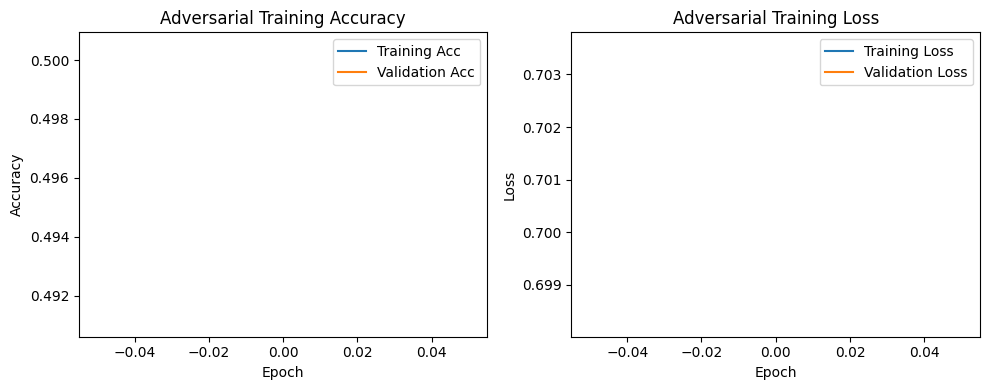

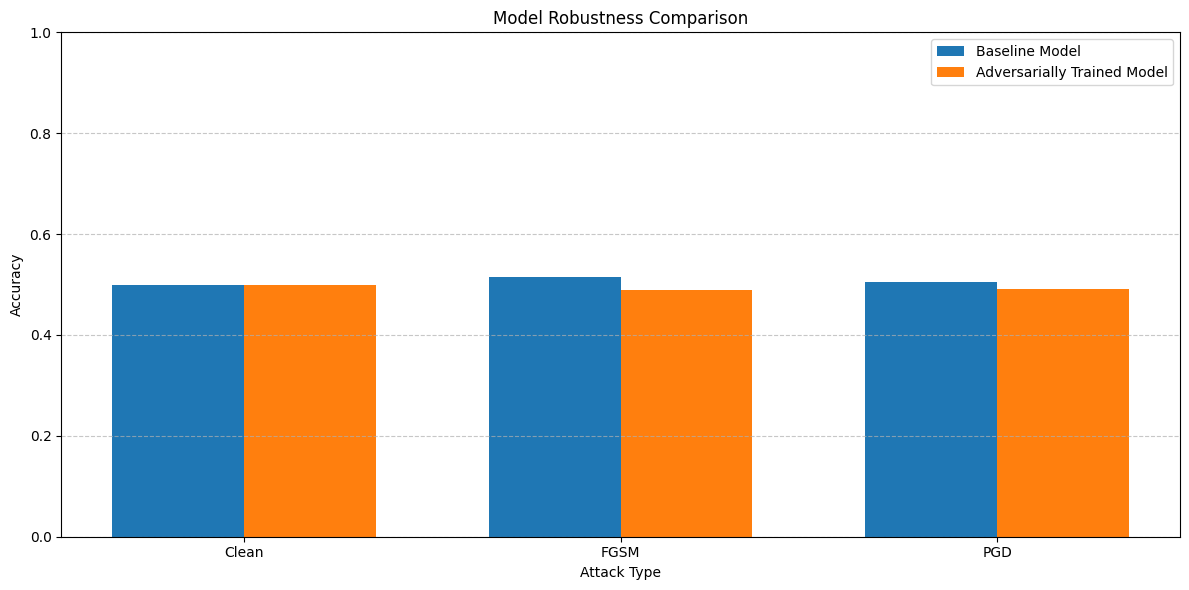

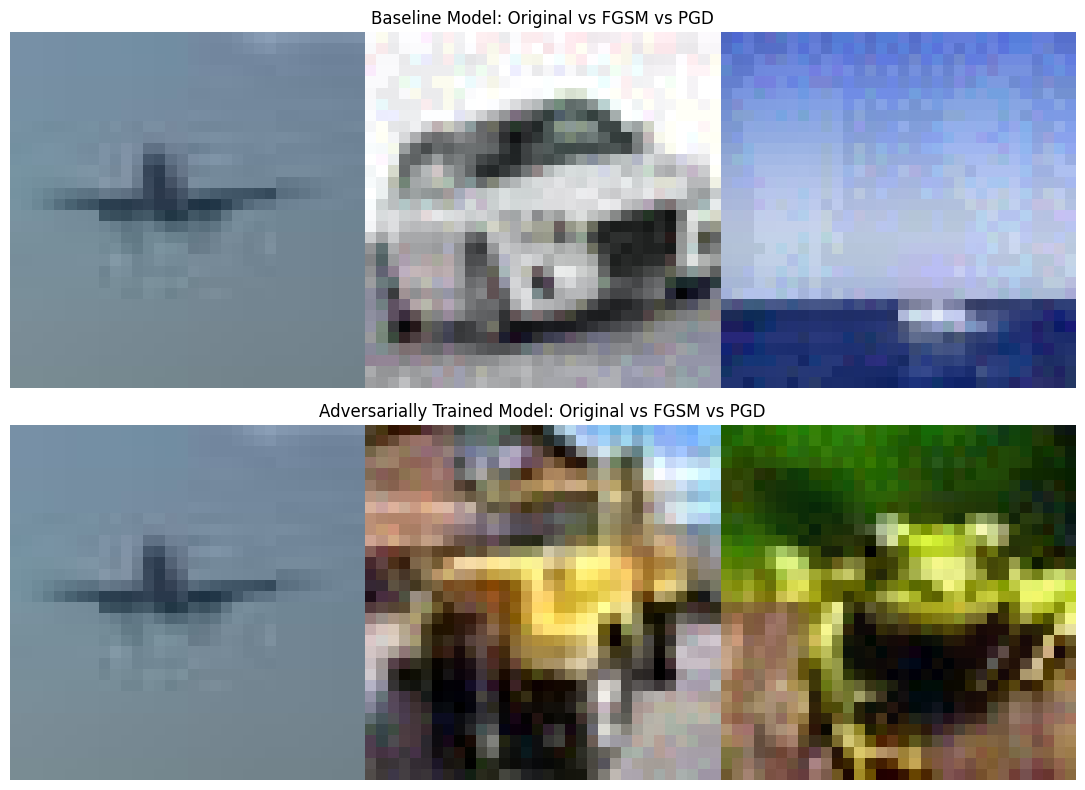

Adversarial examples from adversarially trained model saved!


In [31]:
# Load results from original evaluation for comparison

print("\nComparing baseline vs. adversarially trained model...")

# Create a comparison dictionary for plotting
comparison = {
    'Clean': {'Baseline': clean_acc, 'Adversarial Training': clean_acc},
    'FGSM': {'Baseline': fgsm_acc, 'Adversarial Training': fgsm_acc_adv},
    'PGD': {'Baseline': pgd_acc, 'Adversarial Training': pgd_acc_adv}
}

print("\nAccuracy Comparison:")
print(f"Attack Type    | Baseline Model | Adversarially Trained")
print(f"---------------|----------------|---------------------")
print(f"Clean          | {comparison['Clean']['Baseline']:.4f}         | {comparison['Clean']['Adversarial Training']:.4f}")
print(f"FGSM Attack    | {comparison['FGSM']['Baseline']:.4f}         | {comparison['FGSM']['Adversarial Training']:.4f}")
print(f"PGD Attack     | {comparison['PGD']['Baseline']:.4f}         | {comparison['PGD']['Adversarial Training']:.4f}")

# %% [code] {verticalOutput: true}
# Visualize training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(adv_training_history['binary_accuracy'], label='Training Acc')
plt.plot(adv_training_history['val_binary_accuracy'], label='Validation Acc')
plt.title('Adversarial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(adv_training_history['loss'], label='Training Loss')
plt.plot(adv_training_history['val_loss'], label='Validation Loss')
plt.title('Adversarial Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('adversarial_training_history.png')
plt.show()

# %% [code] {verticalOutput: true}
# Visualize model robustness comparison
plt.figure(figsize=(12, 6))

# Create grouped bar chart for comparison
attacks = list(comparison.keys())
x = np.arange(len(attacks))
width = 0.35

plt.bar(x - width/2, [comparison[attack]['Baseline'] for attack in attacks], 
        width, label='Baseline Model')
plt.bar(x + width/2, [comparison[attack]['Adversarial Training'] for attack in attacks], 
        width, label='Adversarially Trained Model')

plt.xlabel('Attack Type')
plt.ylabel('Accuracy')
plt.title('Model Robustness Comparison')
plt.xticks(x, attacks)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('robustness_comparison.png')
plt.show()

# %% [code] {verticalOutput: true}
# Visualize example adversarial images before and after adversarial training
plt.figure(figsize=(12, 8))

# Original vs adversarial examples from baseline model
plt.subplot(2, 1, 1)
plt.imshow(np.concatenate([X_test[0], X_fgsm[0], X_pgd[0]], axis=1))
plt.title('Baseline Model: Original vs FGSM vs PGD')
plt.axis('off')

# Original vs adversarial examples from adversarially trained model
plt.subplot(2, 1, 2)
plt.imshow(np.concatenate([X_test[0], X_fgsm_adv[0], X_pgd_adv[0]], axis=1))
plt.title('Adversarially Trained Model: Original vs FGSM vs PGD')
plt.axis('off')

plt.tight_layout()
plt.savefig('adversarial_examples_comparison.png')
plt.show()

# %% [code] {verticalOutput: true}
# Save the adversarial examples from the adversarially trained model
np.savez('adversarial_examples_robustified.npz',
         X_clean=X_test[:1000],
         X_fgsm=X_fgsm_adv,
         X_pgd=X_pgd_adv,
         y_test=y_test[:1000])

print("Adversarial examples from adversarially trained model saved!")




Perturbation Statistics:
Model              | Attack | Mean      | Max       | L2 Norm
-------------------|--------|-----------|-----------|----------
Baseline           | FGSM   | 0.282463 | 1.000000 | 0.349930
Baseline           | PGD    | 0.281849 | 1.000000 | 0.348759
Adversarial Trained| FGSM   | 0.281977 | 1.000000 | 0.348347
Adversarial Trained| PGD    | 0.283834 | 1.000000 | 0.351777


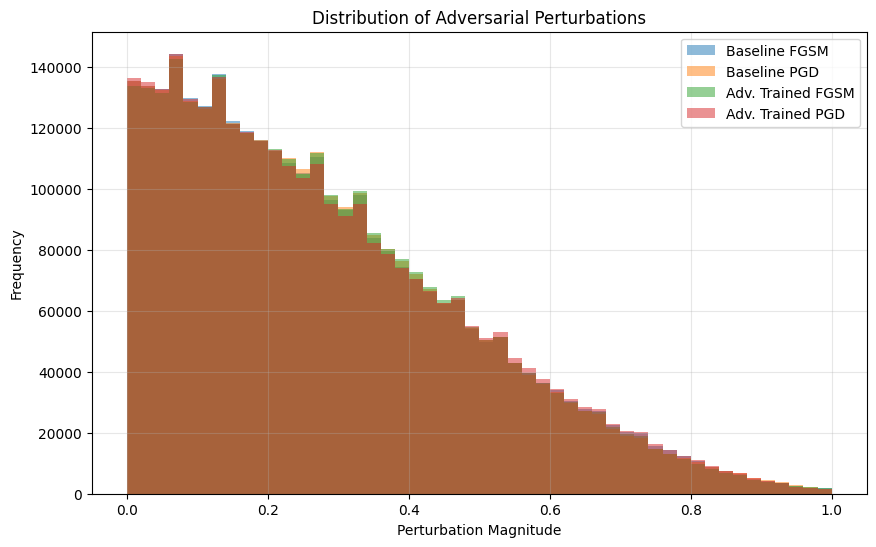

In [32]:
# %% [code] {verticalOutput: true}
# Additional analysis: Visualize perturbation magnitudes
def compute_perturbation_stats(original, perturbed):
    """Compute statistics about perturbations"""
    diff = np.abs(original - perturbed)
    mean_perturbation = np.mean(diff)
    max_perturbation = np.max(diff)
    l2_norm = np.sqrt(np.mean(np.square(diff)))
    return mean_perturbation, max_perturbation, l2_norm

# Compute stats for both models
base_fgsm_mean, base_fgsm_max, base_fgsm_l2 = compute_perturbation_stats(X_test[:1000], X_fgsm[:1000])
base_pgd_mean, base_pgd_max, base_pgd_l2 = compute_perturbation_stats(X_test[:1000], X_pgd[:1000])

adv_fgsm_mean, adv_fgsm_max, adv_fgsm_l2 = compute_perturbation_stats(X_test[:1000], X_fgsm_adv[:1000])
adv_pgd_mean, adv_pgd_max, adv_pgd_l2 = compute_perturbation_stats(X_test[:1000], X_pgd_adv[:1000])

# Create comparison table
print("\nPerturbation Statistics:")
print(f"Model              | Attack | Mean      | Max       | L2 Norm")
print(f"-------------------|--------|-----------|-----------|----------")
print(f"Baseline           | FGSM   | {base_fgsm_mean:.6f} | {base_fgsm_max:.6f} | {base_fgsm_l2:.6f}")
print(f"Baseline           | PGD    | {base_pgd_mean:.6f} | {base_pgd_max:.6f} | {base_pgd_l2:.6f}")
print(f"Adversarial Trained| FGSM   | {adv_fgsm_mean:.6f} | {adv_fgsm_max:.6f} | {adv_fgsm_l2:.6f}")
print(f"Adversarial Trained| PGD    | {adv_pgd_mean:.6f} | {adv_pgd_max:.6f} | {adv_pgd_l2:.6f}")

# Visualize perturbation distributions
plt.figure(figsize=(10, 6))
plt.hist(np.abs(X_test[:1000] - X_fgsm[:1000]).flatten(), bins=50, alpha=0.5, label='Baseline FGSM')
plt.hist(np.abs(X_test[:1000] - X_pgd[:1000]).flatten(), bins=50, alpha=0.5, label='Baseline PGD')
plt.hist(np.abs(X_test[:1000] - X_fgsm_adv[:1000]).flatten(), bins=50, alpha=0.5, label='Adv. Trained FGSM')
plt.hist(np.abs(X_test[:1000] - X_pgd_adv[:1000]).flatten(), bins=50, alpha=0.5, label='Adv. Trained PGD')
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Adversarial Perturbations')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('perturbation_distribution.png')
plt.show()